# 10. Convolutional neural networks

In this assignment you'll use a photo-Z dataset acquired from the observations of the SDSS telescope located in New Mexico. The goal is to predict redshifts from multiband images of galaxies. As a warmup you'll work with the SVHN dataset.

**<font color='red'>[WARN]:</font> For this assignment you'll need significantly more computational power compared to previous assignments! If you don't have a CUDA-capable GPU with >4Gb VRAM and >8Gb RAM, then you're advised to work on Google Colab!**

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, BatchNormalization, Activation, GlobalMaxPool2D
from sklearn.metrics import RocCurveDisplay, confusion_matrix, roc_curve, roc_auc_score,r2_score
from sklearn.model_selection import train_test_split
from random import randint
from extra_keras_datasets import svhn

### 1. Load the Street View House Numbers (SVHN) dataset

-   Download the SVHN database and load the train and test datasets!
    There are multiple ways to do this. The easiest one is probably to install
    and use the `extra-keras-datasets` Python package. You need to use the
    standard/normal SVHN dataset only and NOT the one titled as `extra`!
    (Of course, if you have enough RAM and VRAM, you can work with that one
    too, if you want...)
-   Preprocess the downloaded data if needed to be able to use it for training
    and testing!
-   Normalize the pixel values into the interval of [0,1]!
-   How many and what classes do we have in the dataset? How many train and test
    examples do we have?
-   What are the dimensions of the images?
-   Show some images randomly from the dataset!
-   Make one-hot encoding for the labels!

In [4]:
# Download SVHN database
(x_train, y_train), (x_test, y_test) = svhn.load_data(type='normal')

INFO:root:Loading dataset = svhn


In [5]:
# See dimensions of data sets
print('X_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (73257, 32, 32, 3)
y_train shape:  (73257,)
X_test shape:  (26032, 32, 32, 3)
y_test shape:  (26032,)


In [6]:
# Check classes
labels = np.array(sorted(np.unique(y_test)))
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [7]:
# Function that displays some images randomly if the desired number of images is dividable by 5

def image_show(data,n_image, n_in_row=5):
  fig = plt.figure()
  for i in range(n_image):
    n_row = n_image / n_in_row
    modulo = n_image % n_in_row
    if modulo  == 0:
        n_row = int(n_row)
    else:
        n_row = int(round(n_row,1)) + 1
    # add subplot
    fig.add_subplot(n_row, n_in_row, i+1)
    # get random x_train index values
    idx = randint(0, data.shape[0])
    # display it
    plt.imshow(data[idx])
    plt.axis('off')

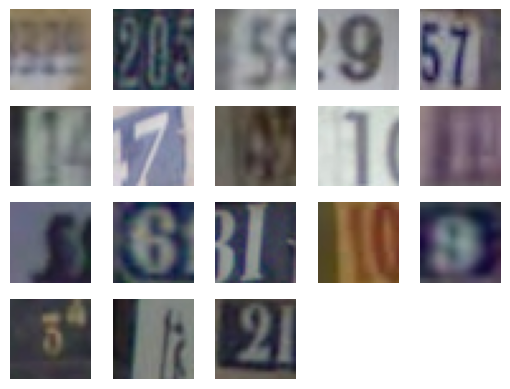

In [8]:
image_show(x_train, 18)

In [9]:
# Preprocces data

# Normalize
# 1st method: by dividing with maximum value which is 255 at the case of image data
x_train = x_train/255
x_test = x_test/255


# 2nd method: by using keras built-in normalize function
#x_train = keras.utils.normalize(x_train)
#x_test = keras.utils.normalize(x_test)

print('x_train: ', x_train[0])
print('\nx_test: ', x_test[0])

x_train:  [[[0.12941176 0.11764706 0.14901961]
  [0.05882353 0.09019608 0.0745098 ]
  [0.05882353 0.06666667 0.0745098 ]
  ...
  [0.28235294 0.25490196 0.21960784]
  [0.32156863 0.30196078 0.22352941]
  [0.34901961 0.30980392 0.23137255]]

 [[0.10980392 0.15294118 0.1372549 ]
  [0.05490196 0.09803922 0.08627451]
  [0.05490196 0.07843137 0.06666667]
  ...
  [0.15686275 0.15294118 0.19607843]
  [0.2627451  0.22745098 0.20392157]
  [0.3254902  0.30588235 0.23529412]]

 [[0.15686275 0.16078431 0.14901961]
  [0.07058824 0.08235294 0.10196078]
  [0.0627451  0.06666667 0.09019608]
  ...
  [0.09019608 0.11372549 0.17647059]
  [0.1372549  0.16470588 0.17254902]
  [0.28235294 0.27058824 0.20784314]]

 ...

 [[0.3372549  0.31764706 0.29411765]
  [0.34117647 0.32156863 0.27843137]
  [0.32156863 0.30980392 0.25490196]
  ...
  [0.40784314 0.40784314 0.34117647]
  [0.40784314 0.41176471 0.31764706]
  [0.40392157 0.41176471 0.30588235]]

 [[0.32941176 0.3372549  0.25098039]
  [0.3372549  0.30980392 0.

In [10]:
# Convert 10 to 0 for one-hot enocoding
y_train = np.where(y_train==10, 0, y_train)
y_test = np.where(y_test==10, 0, y_test)

In [11]:
# One-hot encoding
y_train_oh = keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = keras.utils.to_categorical(y_test, num_classes=10)

In [12]:
# Check one-hot encoding
print('Original y_train: ', y_train[:5])
print('Converted y_train: ', y_train_oh[:5])
print('Original y_test: ', y_test[:5])
print('Converted y_test: ', y_test_oh[:5])

Original y_train:  [1 9 2 3 2]
Converted y_train:  [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Original y_test:  [5 2 1 0 6]
Converted y_test:  [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


### 2. Create a convolutional neural network for the SVHN dataset

-   Train the following network on the training set and generate
    prediction for the test images:
    ```
          > conv2D, 16 kernels, kernel size = (3,3), valid padding, relu actvation
          > conv2D, 16 kernels, kernel size = (3,3), valid padding, relu actvation
          > maxpooling kernel size = (2,2)
          > conv2D, 32 kernels, kernel size = (3,3), valid padding, relu actvation
          > conv2D, 32 kernels, kernel size = (3,3), valid padding, relu actvation
          > maxpooling pool size = (2,2) strides = (2,2)
          > flatten
          > dense, 10 neurons, softmax activation
    ```
    -   Use Adam optimizer with default parameters
    -   Use categorical crossentropy as loss function
    -   Compile the model
    -   Print out a summary of the model
    -   Train the CNN on the training data for 25 epochs with batch size
        of 64
    -   Use the test data as validation data

-   Calculate the categorical cross-entropy loss and the accuracy!
    **<font color='green'>[HINT]:</font>** you should get at least $\approx$ 80-90%
    accuracy.
-   Plot the training and the validation loss and accuracy on the same plot!
    Do we experience overfitting?
-   Show the confusion matrix of the predictions!

In [11]:
# Build convolutional neural network's architecture

cnv_model = Sequential()
cnv_model.add(Conv2D(16, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=x_train.shape[1:]))
cnv_model.add(Conv2D(16, kernel_size=(3, 3), padding='valid', activation='relu'))
cnv_model.add(MaxPooling2D(pool_size=(2, 2)))

cnv_model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu'))
cnv_model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu'))
cnv_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

cnv_model.add(Flatten())
cnv_model.add(Dense(10, activation='softmax'))

# Print model summary
print(cnv_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                    

In [12]:
cnv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Fit the model
cnv_model_history = cnv_model.fit(x=x_train, y=y_train_oh, batch_size=64, epochs=25, validation_data=(x_test, y_test_oh))

Epoch 1/25
1145/1145 [==============================] - 47s 40ms/step - loss: 0.9031 - accuracy: 0.7153 - val_loss: 0.6328 - val_accuracy: 0.8248
Epoch 2/25
1145/1145 [==============================] - 42s 36ms/step - loss: 0.5231 - accuracy: 0.8480 - val_loss: 0.5562 - val_accuracy: 0.8414
Epoch 3/25
1145/1145 [==============================] - 39s 34ms/step - loss: 0.4515 - accuracy: 0.8690 - val_loss: 0.5067 - val_accuracy: 0.8570
Epoch 4/25
1145/1145 [==============================] - 39s 34ms/step - loss: 0.4140 - accuracy: 0.8796 - val_loss: 0.4843 - val_accuracy: 0.8581
Epoch 5/25
1145/1145 [==============================] - 42s 37ms/step - loss: 0.3861 - accuracy: 0.8873 - val_loss: 0.4478 - val_accuracy: 0.8718
Epoch 6/25
1145/1145 [==============================] - 41s 36ms/step - loss: 0.3644 - accuracy: 0.8935 - val_loss: 0.4859 - val_accuracy: 0.8572
Epoch 7/25
1145/1145 [==============================] - 42s 37ms/step - loss: 0.3504 - accuracy: 0.8966 - val_loss: 0.4195 -

In [14]:
# Predict the labels of test set
y_pred = cnv_model.predict(x_test)

# Convert probability prediction into real prediction (highest probability of class is the real prediction)
y_pred_dec = np.array([i.argmax() for i in y_pred])

814/814 [==============================] - 4s 4ms/step


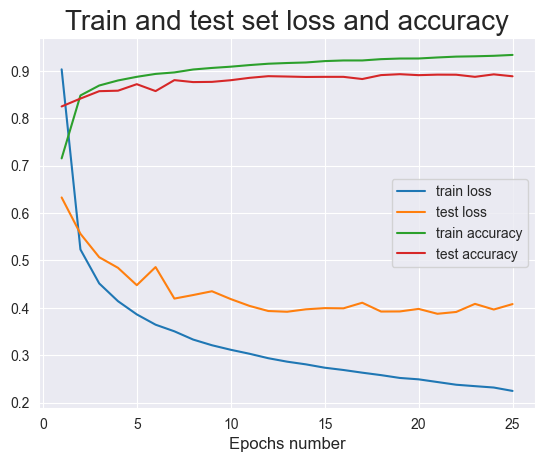

In [15]:
# Plot accuracy and loss on the same plot

train_loss = cnv_model_history.history['loss']
val_loss = cnv_model_history.history['val_loss']
cnv_model_acc = cnv_model_history.history['accuracy']
cnv_model_acc_test = cnv_model_history.history['val_accuracy']

epochs = range(1, 26)
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='test loss')
plt.plot(epochs, cnv_model_acc, label='train accuracy')
plt.plot(epochs, cnv_model_acc_test, label='test accuracy')
plt.title('Train and test set loss and accuracy', fontsize=20)
plt.xlabel('Epochs number', fontsize=12)
plt.legend()


In [16]:
# Confusion matrix
cnf_mtx = confusion_matrix(y_true=y_test, y_pred=y_pred_dec)
cnf_mtx

array([[1525,   44,   20,   26,    2,    3,   54,    7,   19,   44],
       [  31, 4797,   40,   56,   60,   18,   17,   50,   19,   11],
       [   3,   41, 3796,  171,   26,   23,   11,   34,   20,   24],
       [   3,   69,   58, 2563,    7,   43,   20,    6,   48,   65],
       [   6,  156,   32,   62, 2193,   10,   12,   11,   20,   21],
       [   7,   20,   17,  126,   10, 2110,   46,    3,   24,   21],
       [  22,   34,   15,   79,   20,   90, 1629,    6,   68,   14],
       [   5,  124,   50,   40,    7,    5,    4, 1776,    2,    6],
       [  16,   22,   17,  112,   16,   16,   42,    3, 1389,   27],
       [  31,   22,   74,   31,   10,   27,    8,    5,   37, 1350]],
      dtype=int64)

<AxesSubplot: >

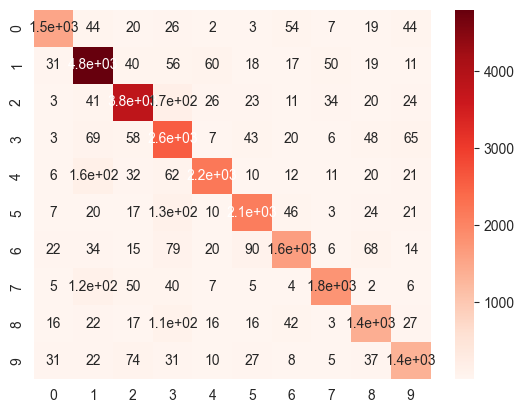

In [17]:
# Display it with seaborn
sns.heatmap(pd.DataFrame(cnf_mtx), annot=True, cmap='Reds')

### 3. Load the Sload Digital Sky Survey (SDSS) Dataset

You can download the dataset from Kaggle via
[this link](https://www.kaggle.com/masterdesky/multiband-photoz-sdss-dr16).

-   Download the images from Kaggle (~10'000 images total) 
-   Preprocess the images similarly to the SVHN dataset if needed! (Normalize
    pixel values to [0,1], etc.)
-   What are the dimensions of the images?
-   Show 15 images randomly from the dataset!
-   Create a train-test-validation split using `train_test_split` from `sklearn`
    where the test size is $0.33$ and the validation size is $0.2$
    -   Set a random seed
    -   Print the number of images in each of these sets after you've created
        them

In [13]:
# Open the dataframe
sky_redshift_df = pd.read_csv("data/skyserver_photoZ_data_DR16.csv",header=0)
sky_redshift_df

,specObjID,ra,dec,z
0,5457255364792963072,179.94568,5.601128,0.611592
1,5457264435763892224,179.87307,5.536654,0.519419
2,947020949721475072,179.87175,5.579883,0.129071
3,5457264985519706112,179.70930,5.616096,0.632514
4,5457265260397613056,179.68102,5.596931,0.682077
...,...,...,...,...
9842,5344779168881332224,179.11661,3.805388,0.519190
9843,5344779718637146112,179.09454,3.816496,0.516736
9844,946960751459854336,178.98641,3.719327,0.080494
9845,579994891963099136,179.00126,3.721930,0.080491


In [14]:
import zipfile
import matplotlib.image as mpimg
from tqdm import tqdm
# Place the images one by one into a list and also their names into another list
zip_images = zipfile.ZipFile('data/images.zip', 'r')
image_arr_list, filenames_list = [], []
cntr = 1
for file_name in tqdm(zip_images.namelist()):
  filenames_list.append(file_name)
  img = zip_images.open(file_name)
  image_arr_list.append(mpimg.imread(img))

100%|██████████| 9847/9847 [00:07<00:00, 1284.53it/s]


In [15]:
image_array = np.array(image_arr_list)
image_array.shape

(9847, 96, 96, 4)

In [16]:
"""
Remove opacity
"""

image_array =np.delete(image_array, -1, 3)
image_array.shape

(9847, 96, 96, 3)

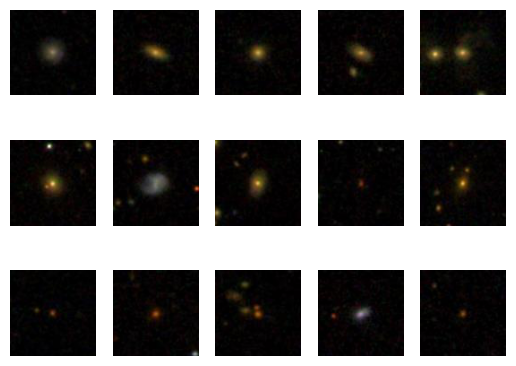

In [17]:
# Plot 15 images randomly
image_show(image_array, 15)

In [18]:
# Normalize data
image_array_norm = image_array[:,]/255

image_array_norm[:2]

array([[[[1.3840832e-04, 1.3840832e-04, 1.3840832e-04],
         [9.2272203e-05, 9.2272203e-05, 9.2272203e-05],
         [3.0757405e-05, 3.0757405e-05, 3.0757405e-05],
         ...,
         [4.6136101e-05, 4.6136101e-05, 4.6136101e-05],
         [3.0757405e-05, 6.1514809e-05, 4.6136101e-05],
         [3.0757405e-05, 6.1514809e-05, 4.6136101e-05]],

        [[1.2302962e-04, 1.2302962e-04, 1.2302962e-04],
         [7.6893506e-05, 7.6893506e-05, 7.6893506e-05],
         [4.6136101e-05, 4.6136101e-05, 4.6136101e-05],
         ...,
         [6.1514809e-05, 6.1514809e-05, 6.1514809e-05],
         [6.1514809e-05, 9.2272203e-05, 7.6893506e-05],
         [6.1514809e-05, 9.2272203e-05, 7.6893506e-05]],

        [[7.6893506e-05, 7.6893506e-05, 7.6893506e-05],
         [6.1514809e-05, 6.1514809e-05, 6.1514809e-05],
         [4.6136101e-05, 4.6136101e-05, 4.6136101e-05],
         ...,
         [6.1514809e-05, 6.1514809e-05, 6.1514809e-05],
         [7.6893506e-05, 1.0765091e-04, 9.2272203e-05],
  

In [19]:
# Extract labels (redshift) from dataframe
y = sky_redshift_df['z']

# Check the order is the same or not with order of images by using the names list
print(y[:5])
print(filenames_list[:5])

0    0.611592
1    0.519419
2    0.129071
3    0.632514
4    0.682077
Name: z, dtype: float64
['00000_id5.457255364792963e+18_z0.6115918.png', '00001_id5.457264435763892e+18_z0.5194192.png', '00002_id9.470209497214751e+17_z0.1290712.png', '00003_id5.457264985519706e+18_z0.6325144.png', '00004_id5.457265260397613e+18_z0.6820772.png']


In [20]:
# Order the z values (y) as the same as images and filenames in the list and in the array
y = []
# Loop through filenames in the list (filenames' order is the same as images' order in image_array)
for filename in filenames_list:
  # if the id is 00000 then select the redshift value in the first row of dataframe
  if filename.startswith('00000'):
    #print(filename)
    #print('id: {}'.format(id))
    # extract corresponding redshift value from dataset
    redshift_val = sky_redshift_df.iloc[0, 3]
  else:
    id = int(filename[:5].lstrip('0'))
    #print(id)
    redshift_val = sky_redshift_df.iloc[id, 3]
  y.append(redshift_val)

y = np.array(y)
y = y.reshape(9847, 1)

In [21]:
# Check the orders now again
print(y[:5])
print(filenames_list[:5])

[[0.6115918]
 [0.5194192]
 [0.1290712]
 [0.6325144]
 [0.6820772]]
['00000_id5.457255364792963e+18_z0.6115918.png', '00001_id5.457264435763892e+18_z0.5194192.png', '00002_id9.470209497214751e+17_z0.1290712.png', '00003_id5.457264985519706e+18_z0.6325144.png', '00004_id5.457265260397613e+18_z0.6820772.png']


In [22]:
# Split data and label
x_train, x_test, y_train, y_test = train_test_split(image_array_norm, y, test_size=0.33, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

print('x_train: {}\ty_train: {}'.format(x_train.shape[0], len(y_train)))
print('x_test: {}\ty_test: {}'.format(x_test.shape[0], len(y_test)))
print('x_val: {}\ty_val: {}'.format(x_val.shape[0], len(y_val)))

x_train: 5277	y_train: 5277
x_test: 3250	y_test: 3250
x_val: 1320	y_val: 1320


# 4. Create a convolutional neural network for the SDSS dataset
Train the following network on the training set and generate prediction for the test images:

      > conv2D, 32 kernels, kernel size = (3,3), same padding
      > batch normalization
      > relu actvation
      > conv2D, 32 kernels, kernel size = (3,3), same padding
      > batch normalization
      > relu actvation
      > maxpooling pool size = (2,2), strides = (2,2)

      > conv2D, 64 kernels, kernel size = (3,3), same padding
      > batch normalization
      > relu actvation
      > conv2D, 64 kernels, kernel size = (1,1), same padding
      > batch normalization
      > relu actvation
      > conv2D, 64 kernels, kernel size = (3,3), same padding
      > batch normalization
      > relu actvation
      > maxpooling pool size = (2,2), strides = (2,2)

      > global pooling
      > dense, 1 neuron, no activation
Use Adam optimizer with default parameters
Use mean squared error as loss function
Compile the model
Print out a summary of the model
Use the created validation set as validation during the training
Train the CNN on the training data for 25 epochs with batch size of 64
Calculate and print out the final accuracy using the R2 score!

In [37]:
# Build convolutional neural network's architecture

cnv_model = Sequential()
cnv_model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:]))
cnv_model.add(BatchNormalization())
cnv_model.add(Activation('relu'))
cnv_model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
cnv_model.add(BatchNormalization())
cnv_model.add(Activation('relu'))
cnv_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

cnv_model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
cnv_model.add(BatchNormalization())
cnv_model.add(Activation('relu'))
cnv_model.add(Conv2D(64, kernel_size=(1, 1), padding='same'))
cnv_model.add(BatchNormalization())
cnv_model.add(Activation('relu'))
cnv_model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
cnv_model.add(BatchNormalization())
cnv_model.add(Activation('relu'))
cnv_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

cnv_model.add(GlobalMaxPool2D())
cnv_model.add(Dense(1))

# Print model summary
print(cnv_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_5 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 96, 96, 32)       

In [38]:
cnv_model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()])

In [39]:
# Fit the model
cnv_model_history = cnv_model.fit(x=x_train, y=y_train, batch_size=64, epochs=25, validation_data=(x_val, y_val))

Epoch 1/25
83/83 [==============================] - 97s 1s/step - loss: 3.5160 - mean_squared_error: 3.5160 - val_loss: 1.0983 - val_mean_squared_error: 1.0983
Epoch 2/25
83/83 [==============================] - 101s 1s/step - loss: 0.1140 - mean_squared_error: 0.1140 - val_loss: 1.8678 - val_mean_squared_error: 1.8678
Epoch 3/25
83/83 [==============================] - 107s 1s/step - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 1.9902 - val_mean_squared_error: 1.9902
Epoch 4/25
83/83 [==============================] - 107s 1s/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 1.8986 - val_mean_squared_error: 1.8986
Epoch 5/25
83/83 [==============================] - 96s 1s/step - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 1.9975 - val_mean_squared_error: 1.9975
Epoch 6/25
83/83 [==============================] - 92s 1s/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 1.2558 - val_mean_squared_error: 1.2558
Epoch 7/25
83/83 [===================

In [40]:
# Predict with the model
y_pred = cnv_model.predict(x_test)

102/102 [==============================] - 14s 131ms/step


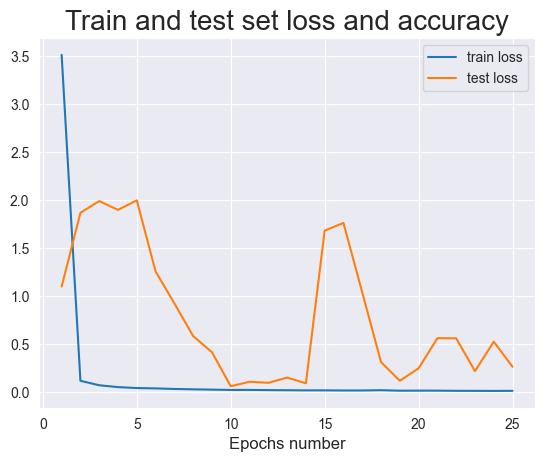

In [54]:
train_loss = cnv_model_history.history['loss']
val_loss = cnv_model_history.history['val_loss']
cnv_model_mean_squared = cnv_model_history.history['mean_squared_error']
val_cnv_model_mean_squared = cnv_model_history.history['val_mean_squared_error']

epochs = range(1, 26)
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='test loss')
plt.title('Train and test set loss', fontsize=20)
plt.xlabel('Epochs number', fontsize=12)
plt.legend()

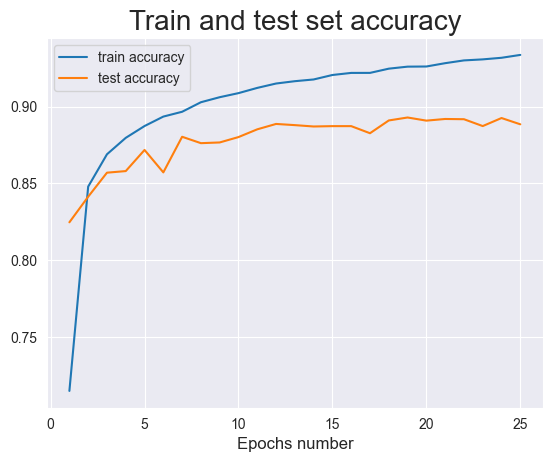

In [57]:
epochs = range(1, 26)
plt.plot(epochs, cnv_model_acc, label='train accuracy')
plt.plot(epochs, cnv_model_acc_test, label='test accuracy')
plt.title('Train and test set accuracy', fontsize=20)
plt.xlabel('Epochs number', fontsize=12)
plt.legend()

### 5. Evaluate performance

-   Plot the training and the validation loss on the same plot!
-   Show the predicted values vs the actual labels on a plot!
-   Where does the model make mistakes? Try to plot the images corresponding to
    some outlier values!

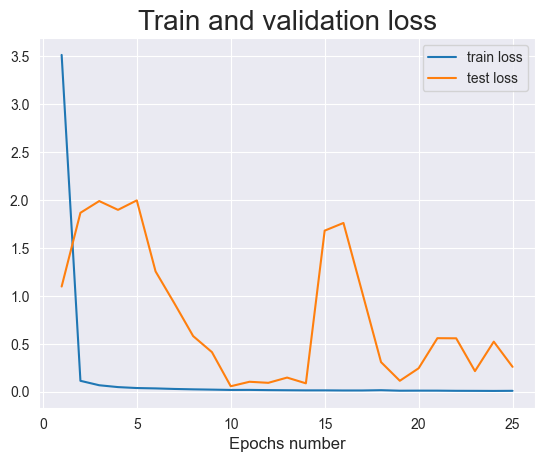

In [45]:

# Plot accuracy and loss on the same plot

train_loss = cnv_model_history.history['loss']
val_loss = cnv_model_history.history['val_loss']

epochs = range(1, 26)
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('Train and validation loss', fontsize=20)
plt.xlabel('Epochs number', fontsize=12)
plt.legend()

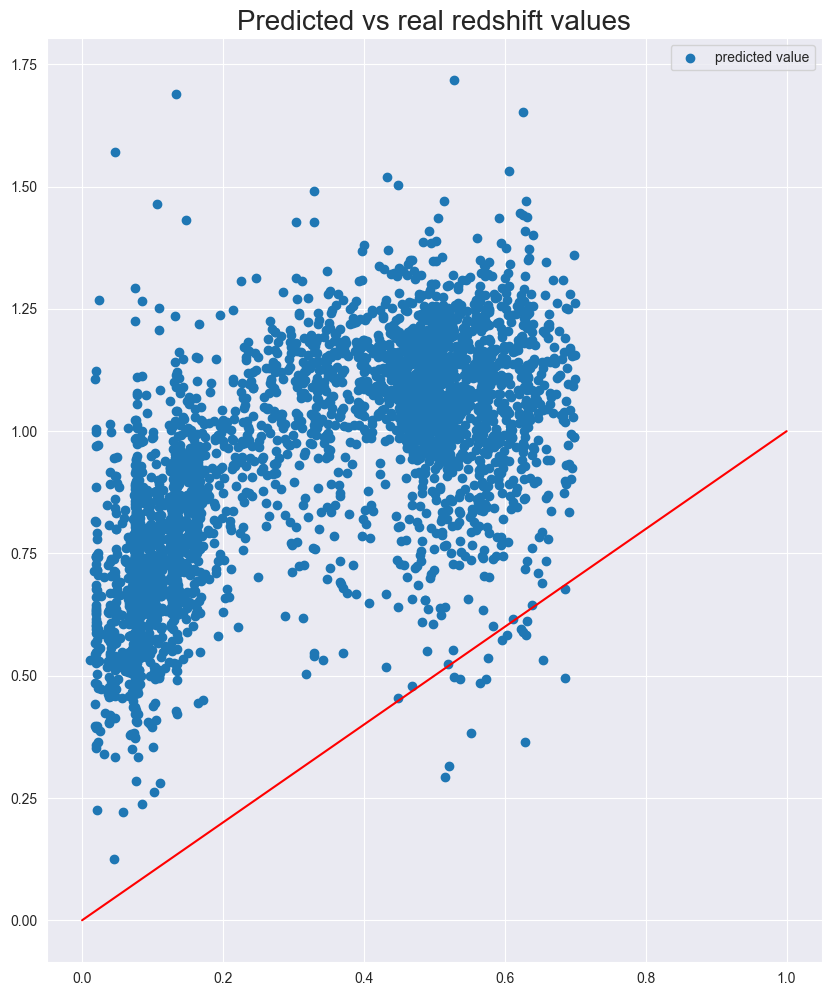

In [61]:
# PLot predicted and real labels

plt.figure(figsize=(10, 12))
plt.title('Predicted vs real redshift values', fontsize=20)

# plt.scatter([i for i in range(len(y_test))], y_test, label='real value')
# plt.scatter([i for i in range(len(y_pred))], y_pred, label='predicted value')
plt.scatter(y_test, y_pred, label='predicted value')
plt.plot([0,1],[0,1],"-r")
plt.legend()

[[-0.3261097 ]
 [-0.0158101 ]
 [ 0.11013041]
 ...
 [-0.26437494]
 [-0.08464655]
 [-0.8728102 ]]


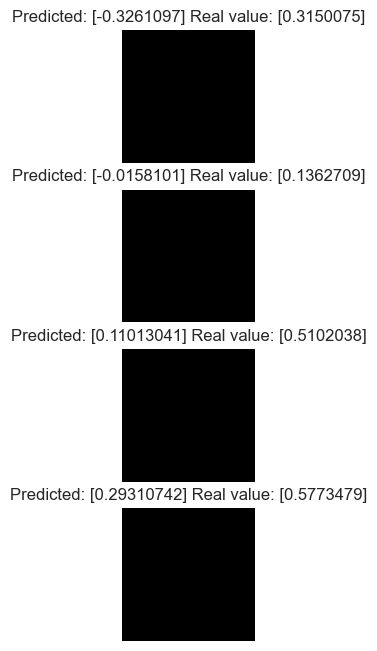

In [61]:
# Plot wrong predictions

plt.figure(figsize=(15, 10))
dim = 1
# loop through predictions
for id, pred in enumerate(y_pred):
  # Not plot more than 15 cases when the prediction is wrong
  if dim == 5:
    break
  else:
    # if predicted label not the real label then plot it
    if pred != y_test[id]:
      plt.subplot(5, 1, dim)
      plt.title('Predicted: {} Real value: {}'.format(pred, y_test[id]))
      plt.imshow(x_test[id],cmap='hot')
      plt.axis('off')
      dim += 1


### 6. Train an other CNN

-   The previous architecture can be further improved.
-   Come up with an architecture that can achieve more than 80-85% accuracy on 
    the test set if the accuracy metric is the R2 score!
    -   You can use any tool for this task.
    -   Remember that there are different losses and optimizers, early stopping,
        regularization, etc. that can be useful for you. You can find more about 
        these eg. in the
        [tensorflow/keras documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols).
    -   Don't forget that you can add more layers to the model and train for
        more epochs too... :)
-   Print out the summary of this model!
-   Plot the loss curves for this model too!

In [54]:
cnv_model_mine = Sequential()
cnv_model_mine.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:]))
cnv_model_mine.add(BatchNormalization())
cnv_model_mine.add(Activation('relu'))
cnv_model_mine.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
cnv_model_mine.add(BatchNormalization())
cnv_model_mine.add(Activation('relu'))
cnv_model_mine.add(Conv2D(64, kernel_size=(1, 1), padding='same'))
cnv_model_mine.add(BatchNormalization())
cnv_model_mine.add(Activation('relu'))
cnv_model_mine.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
cnv_model_mine.add(BatchNormalization())
cnv_model_mine.add(Activation('relu'))
cnv_model_mine.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

cnv_model_mine.add(GlobalMaxPool2D())
cnv_model_mine.add(Dense(1))

# Print model summary
print(cnv_model_mine.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_9 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 96, 96, 64)       

In [55]:
cnv_model_mine.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanSquaredError()])

In [56]:
mine_history = cnv_model_mine.fit(x=x_train, y=y_train, batch_size=50, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
106/106 [==============================] - 191s 2s/step - loss: 3.2687 - mean_squared_error: 3.2687 - val_loss: 0.5518 - val_mean_squared_error: 0.5518
Epoch 2/20
106/106 [==============================] - 189s 2s/step - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.7998 - val_mean_squared_error: 0.7998
Epoch 3/20
106/106 [==============================] - 189s 2s/step - loss: 0.0553 - mean_squared_error: 0.0553 - val_loss: 0.7884 - val_mean_squared_error: 0.7884
Epoch 4/20
106/106 [==============================] - 189s 2s/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.4395 - val_mean_squared_error: 0.4395
Epoch 5/20
106/106 [==============================] - 189s 2s/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.1655 - val_mean_squared_error: 0.1655
Epoch 6/20
106/106 [==============================] - 191s 2s/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.2296 - val_mean_squared_error: 0.2296
Epoch 7/20
106/106 [==

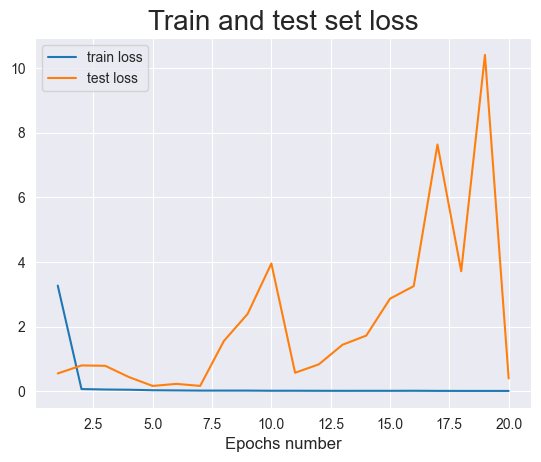

In [57]:
train_loss = mine_history.history['loss']
val_loss = mine_history.history['val_loss']

epochs = range(1,21)
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='test loss')
plt.title('Train and test set loss', fontsize=20)
plt.xlabel('Epochs number', fontsize=12)
plt.legend()

In [58]:
y_pred = cnv_model_mine.predict(x_test)

102/102 [==============================] - 32s 302ms/step


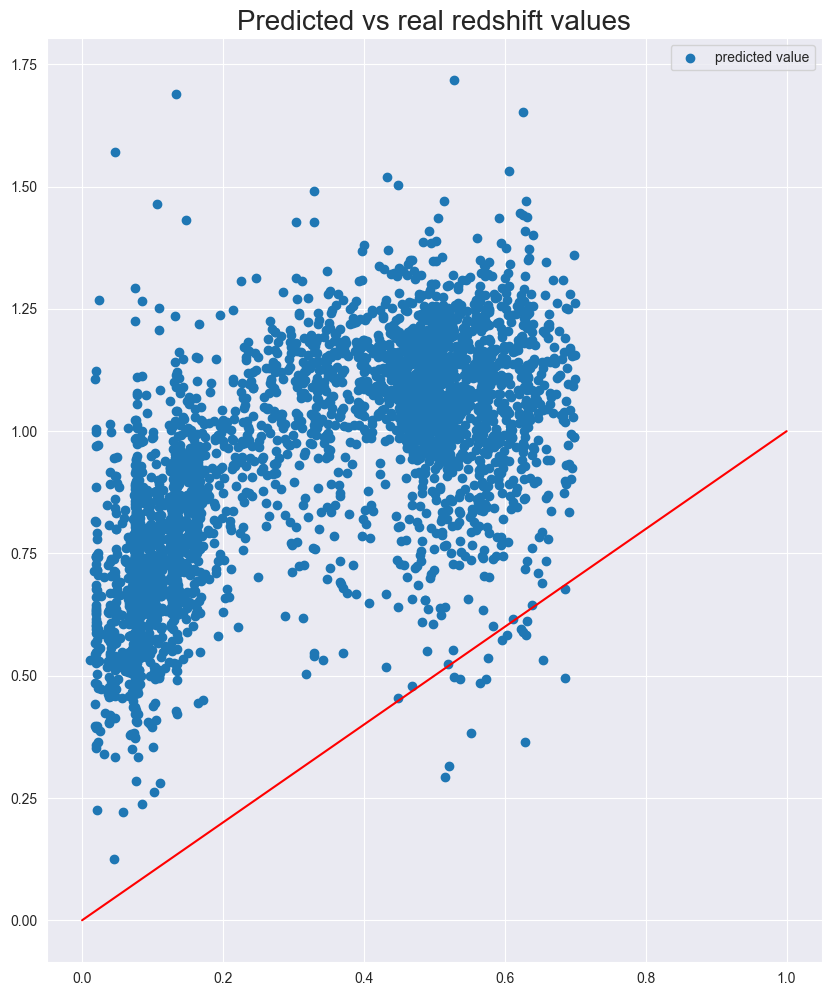

In [62]:
# PLot predicted and real labels

plt.figure(figsize=(10, 12))
plt.title('Predicted vs real redshift values', fontsize=20)

plt.scatter(y_test, y_pred, label='predicted value')
plt.plot([0,1],[0,1],"-r")
plt.legend()